<a href="https://colab.research.google.com/github/themathedges/3YP-Standalone-Kennington/blob/main/Ravi/Preprocessing_notebooks/Precipitation_cross_correlation_exploration_square_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upstream Precipitation Cross Correlation Exploration for Grid Square 3

**Author:** Ravi Kohli

**College:** Christ Church

**Date:** January 12th, 2021

**Goal:**
- To calculate the temporal cross-correlation between the precipitation data upstream and the daily Sandford generation and find the optimal time lag
- This notebook will be for grid-square 3

In [ ]:
# Mounting the Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# import the modules
import numpy as np
import pandas as pd
from pandas import Timestamp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy.stats import pearsonr
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

## Import the Data

### Sandford Daily Generation Data

In [ ]:
# unpickle the processed daily generation dataframe
path = '/content/drive/My Drive/3YP/data/'
filename = 'daily_sandford_generation_data'
infile = open(path+filename, 'rb')
sandford_daily_df = pickle.load(infile)
infile.close()

In [ ]:
sandford_daily_df

,Reading Date,Incremental Reading,Meter Reading
0,2019-10-22,1284.10,1763145.53
1,2019-10-21,1175.01,1761861.43
2,2019-10-20,1175.01,NaN
3,2019-10-19,1175.01,NaN
4,2019-10-18,2265.09,1758336.41
...,...,...,...
364,2018-10-22,0.00,548149.91
365,2018-10-21,0.00,548149.91
366,2018-10-20,0.00,548149.91
367,2018-10-19,0.00,548149.91


### Upstream Precipitation Data

In [ ]:
# unpickle the processed daily generation dataframe
path = '/content/drive/My Drive/3YP/data/met_office/'
filename = 'precip_2242_upstream3_met_daily'
infile = open(path+filename, 'rb')
upstream_precip_daily_df = pickle.load(infile)
infile.close()

In [ ]:
upstream_precip_daily_df

,Date,Precipitation
0,1980-12-01,0.034366
1,1980-12-02,0.705222
2,1980-12-03,2.868936
3,1980-12-04,0.157865
4,1980-12-05,1.123900
...,...,...
25225,2050-12-26,0.002720
25226,2050-12-27,6.750660
25227,2050-12-28,3.676629
25228,2050-12-29,0.092938


In [ ]:
# define a mask to extract the rows from upstream precip_daily_df which have the same date as the generation data
# format of mask: YYYY-MM-DD
upstream_mask_start = pd.to_datetime(min(sandford_daily_df['Reading Date']))
upstream_mask_end = pd.to_datetime(max(sandford_daily_df['Reading Date']))

In [ ]:
upstream_mask = (upstream_precip_daily_df['Date'] >= upstream_mask_start) & (upstream_precip_daily_df['Date'] <= upstream_mask_end)

# extract the rows from the dataframe by using the mask
upstream_extracted_df = upstream_precip_daily_df.loc[upstream_mask]

In [ ]:
upstream_extracted_df

,Date,Precipitation
13637,2018-10-18,0.247176
13638,2018-10-19,0.010691
13639,2018-10-20,2.439899
13640,2018-10-21,0.448772
13641,2018-10-22,1.939366
...,...,...
13997,2019-10-18,0.322296
13998,2019-10-19,0.001850
13999,2019-10-20,0.046937
14000,2019-10-21,5.507039


we notice that `upstream_extracted_df` is shorter than `sandford_daily_df`, so we need to remove those dates not in the precipitation data

In [ ]:
len(upstream_extracted_df['Date']), len(sandford_daily_df['Reading Date'])

(363, 369)

In [ ]:
dates_to_remove = set(sandford_daily_df['Reading Date']) - set(upstream_extracted_df['Date'])
dates_to_remove

{Timestamp('2018-10-31 00:00:00'),
 Timestamp('2018-12-31 00:00:00'),
 Timestamp('2019-01-31 00:00:00'),
 Timestamp('2019-03-31 00:00:00'),
 Timestamp('2019-05-31 00:00:00'),
 Timestamp('2019-07-31 00:00:00'),
 Timestamp('2019-08-31 00:00:00')}

In [ ]:
# iterating through the list of dates and removing them
sandford_daily_reduced = sandford_daily_df
for i in dates_to_remove:
  sandford_daily_reduced = sandford_daily_reduced[sandford_daily_reduced['Reading Date'] != i]

In [ ]:
# there is a date in the precipitation data that isn't in the generation data and therefore needs to be removed
dates_to_remove_pt2 = set(upstream_extracted_df['Date']) - set(sandford_daily_reduced['Reading Date'])
dates_to_remove_pt2

{Timestamp('2019-06-01 00:00:00')}

In [ ]:
upstream_reduced = upstream_extracted_df[upstream_extracted_df['Date'] != list(dates_to_remove_pt2)[0]]

We now have two dataframes of length 362:
- `upstream_reduced`
- `sandford_daily_reduced`

In [ ]:
upstream_reduced.reset_index(drop=True)

,Date,Precipitation
0,2018-10-18,0.247176
1,2018-10-19,0.010691
2,2018-10-20,2.439899
3,2018-10-21,0.448772
4,2018-10-22,1.939366
...,...,...
357,2019-10-18,0.322296
358,2019-10-19,0.001850
359,2019-10-20,0.046937
360,2019-10-21,5.507039


## Temporal Cross-Correlation Analysis

This code was obtained from: https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

In [ ]:
# define this function to find the temporal cross correlation
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

The code below was obtained from: https://stackoverflow.com/questions/33171413/cross-correlation-time-lag-correlation-with-pandas

In [ ]:
def crosscorr2(datax, datay, lag=0):
    """ Lag-N cross correlation. 
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    return datax.corr(datay.shift(lag))

In [ ]:
# defining the datasets
d1 = sandford_daily_reduced['Incremental Reading']
d2 = upstream_reduced['Precipitation']

d1_ser = pd.Series(d1.values)
d2_ser = pd.Series(d2.values)

In [ ]:
len(d1_ser)

362

In [ ]:
start_lag = -25                                                                 # define one end of the lag range
end_lag = 25 + 1                                                                # define other end of the lag range
lag_linspace = [i for i in range(start_lag, end_lag)]                           # define list of dates to plot in graph
xcov_daily = [crosscorr2(d1_ser, d2_ser, lag=i) for i in range(start_lag, end_lag)]   # calculate cross-correlations as a function of lag

In [ ]:
#xcov_daily

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


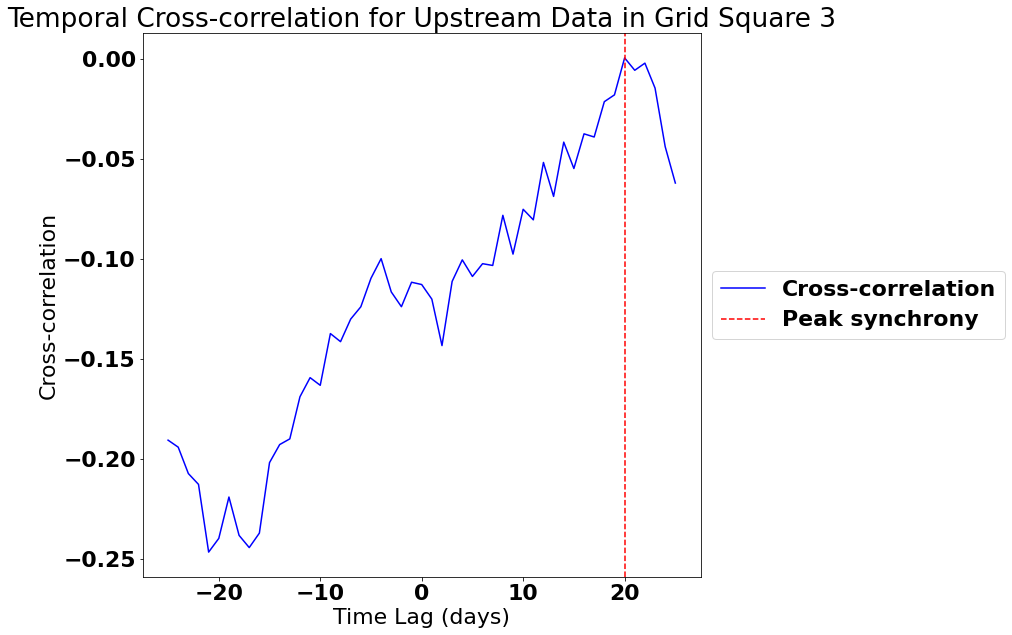

In [ ]:
# Let us plot the generation profile
corr_fig, corr_ax = plt.subplots(figsize = (10, 10))
corr_ax.plot(lag_linspace, xcov_daily, 'b', label = 'Cross-correlation')  
corr_ax.axvline(lag_linspace[np.argmax(xcov_daily)], color='r', linestyle='--', label = 'Peak synchrony')           # Putting a line for peak synchrony
corr_ax.set(title = 'Temporal Cross-correlation for Upstream Data in Grid Square 3', xlabel= 'Time Lag (days)', ylabel='Cross-correlation')
corr_ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)